In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


from models import DeepConditionalModel, InvariantNetwork
from losses import maximum_likelihood_loss
from inn_utils import train_loop_active
from viz import plot_losses

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
plt.rcParams['font.size'] = 14

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

In [5]:
tf.enable_eager_execution()

## Bayesian linear regression class

<p>In this example, we train a cINN to approximate the posterior distribution of the regression weights of a Bayesian linear regression model.</p>
<hr>
<p><strong>Setting:</strong></p>
<p>Assume we have observed $n$ pairs of data points:</p>
$$D = \{(\mathbf{x}_{i}, y_{i})\}_{i=1,...,n}$$
<p>where</p>
$$\mathbf{x} \in \mathbb{R}^d, y \in \mathbb{R}$$
<p><strong>Model:</strong></p>
<p>We model each $y_{i}$ as being drawn from a Gaussian distribution paramaterized by:</p>
$$y_{i} \sim \mathcal{N}(\mathbf{\beta}^T\mathbf{x}, a^{-1})$$
<p>where $a$ is the precision, (i.e., inverse variance), so $a = \dfrac{1}{\sigma_{y}^2}$</p>
<p>We place the followng prior on the regression weights:</p>
$$\beta \sim \mathcal{N}_{d}(\mathbf{0}, b^{-1}\mathbf{I}_{d})$$
<p>where $\mathcal{N}_{d}(., .)$ denotes a $d$-dimensional Gaussian distribtuion</p> and $b$ is the precision of the distribution, i.e. $b = \dfrac{1}{\sigma_{\beta}^2}$.
<p>When $a$ and $b$ are known, the likelihood $p(D|\mathbf{\beta})$ is proportional to:</p>
$$p(D|\mathbf{\beta}) \propto \exp(-\dfrac{a}{2}(y - \mathbf{X}\mathbf{\beta})^T(y - \mathbf{X}\mathbf{\beta}))$$
<p>and the posterior of $\mathbf{\beta}$ is proportional to:</p>
$$p(\mathbf{\beta}|D) \propto \exp(-\dfrac{a}{2}(y - \mathbf{X}\mathbf{\beta})^T(y - \mathbf{X}\mathbf{\beta}) - \dfrac{b}{2}\mathbf{\beta}^T\mathbf{\beta})$$
<p>where $X$ is the design matrix in which each row $i$ represents $\mathbf{x}_{i}^T$. Since the prior is conjugate to the likelihood, the posterior is also Gaussian with the following form:</p>
$$p(\mathbf{\beta}|D) = \mathcal{N}_{d}(\mathbf{\beta}|\mathbf{\mu}, \mathbf{\Lambda}^{-1})$$
<p>where $\mathbf{\Lambda}$ is the precision matrix (inverse covariance matrix) and the posterior mean and covariance are calculated as follows:</p>
<br>
$$\mathbf{\Lambda} = a\mathbf{X}^T\mathbf{X} + b\mathbf{I}_{d}$$
$$\mathbf{\mu} = a\mathbf{\Lambda}^{-1}\mathbf{X}^T\mathbf{y}$$
<p>The preceding calculation are implemented in the class <em>BayesianLinearRegression</em> defined below.</p>

In [6]:
class BayesianLinearRegression:
    
    def __init__(self, theta_dim, b=1., a=1.):
        self.theta_dim = theta_dim
        self.b = b # Precision of p(w|b) ~ N(0, b^-1I)
        self.a = a # Precision of p(y | beta.Tx, a^-1)
        self.Ix = np.identity(self.theta_dim)
        self.prior_beta = stats.multivariate_normal(np.zeros(self.theta_dim), (1/self.b) * self.Ix)
        
    def _generate_design_mat(self, n_samples):
        return np.random.randn(n_samples, self.theta_dim)
    
    def _sample_beta(self):
        """Prior on beta is a normal N(0, b^-1I)."""
        return self.prior_beta.rvs()
    
    def generate_data(self, n_samples):
        """Generates a single regression dataset."""
        
        X = self._generate_design_mat(n_samples)
        beta = self._sample_beta()
        y = X @ beta + np.random.normal(0., np.sqrt((1/self.a)), n_samples)
        return np.c_[X, y], beta
    
    def generate_multiple_datasets(self, n_datasets, to_tensor=True, n=None):
        """Generates multiple regression datasets by calling generate_data() multiple times."""
        
        # Draw n from U(50, 500), if n not fixed
        if n is None:
            n = np.random.randint(50, 501)
        
        X = np.zeros((n_datasets, n, self.theta_dim+1))
        betas = np.zeros((n_datasets, self.theta_dim))
        
        for i in range(n_datasets):
            D, beta = self.generate_data(n)
            X[i] = D
            betas[i] = beta
        if to_tensor:
            return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(betas, dtype=tf.float32)
        return X, betas
    
    def posterior_beta(self, D, n_samples=None):
        """Computes the posterior of beta given data as described above."""
        
        # Extract X and y
        X = D[:, :self.theta_dim]
        y = D[:, self.theta_dim]
        
        # Compute mean and cov of Gaussian posterior
        cov = np.linalg.inv(self.a * X.T @ X + self.b * self.Ix)
        mu = self.a * cov @ X.T @ y
        
        if n_samples is None:
            return stats.multivariate_normal(mu, cov)
        return stats.multivariate_normal(mu, cov).rvs(n_samples)
    
    def __call__(self, n_datasets, to_tensor=True, n=None):
        """Makes instances of the class callable."""
        return self.generate_multiple_datasets(n_datasets, to_tensor=True, n=n)

# Functions

## Utility Functions

In [7]:
def plot_true_est_posterior(model, reg, n_samples, X_test, Y_test, params_names, 
                            figsize=(15, 20), filename=None):
    """Plots X_test.shape[0] rows of posterior samples vs true means."""
    
    # Initialize figure
    n_sim = X_test.numpy().shape[0]
    f, axarr = plt.subplots(n_sim, len(params_names), figsize=figsize)
    
    
    # Sample from approximate posterior given current Y
    if model is not None:
        X_samples = model.sample(Y_test, n_samples).numpy()
        X_samples_means = X_samples.mean(axis=0)
    
    # For each row 
    for i in range(n_sim):
        
        # Sample from true posterior given current Y
        X_analytic_samples = reg.posterior_beta(Y_test[i].numpy(), n_samples=n_samples)
        X_analytic_means = X_analytic_samples.mean(axis=0)
        
        # Extracttrue data generating values
        X_true = X_test.numpy()[i]
        
        for j in range(len(params_names)):
            
            # Plot KDE of approximate posterior, of model specified
            if model is not None:
                sns.distplot(X_samples[:, i, j], kde=True, hist=True, ax=axarr[i, j], 
                             label='Estimated', color='#5c92e8')
            # Plot KDE of analytic posterior
            sns.distplot(X_analytic_samples[:, j], kde=True, hist=True, ax=axarr[i, j], 
                         label='Analytic', color='#e55e5e')
            
            # Plot lines for approximate mean, analytic mean and true data-generating value
            if model is not None:
                axarr[i, j].axvline(X_samples_means[i, j], color='#5c92e8')
            axarr[i, j].axvline(X_analytic_means[j], color='#e55e5e')
            axarr[i, j].axvline(X_true[j], color='black', label='True')
            axarr[i, j].spines['right'].set_visible(False)
            axarr[i, j].spines['top'].set_visible(False)
            
            # Set title of first row
            if i == 0:
                axarr[i, j].set_title(params_names[j])
            
            if i == 0 and j == 0:
                axarr[i, j].legend(fontsize=10)
            
    f.tight_layout()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_density.png".format(filename, Y_test.shape[1]), dpi=600)
        
    plt.show()
    
    
def plot_true_est_scatter(model, reg, n_samples, X_test, theta_test, 
                          params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    # Initialize figure
    f, axarr = plt.subplots(1, len(params_names), figsize=figsize)

    
    # --- Sample parameter from approx posterior and calculate means and vars --- #
    theta_samples = model.sample(X_test, n_samples).numpy()
    theta_samples_means = theta_samples.mean(axis=0)
        
    # --- Compute analytic posterior and extract mean--- #
    theta_true_means = np.zeros_like(theta_test.numpy())
    for i in range(X_test.shape[0]): 
        post = reg.posterior_beta(X_test[i].numpy())
        theta_true_means[i, :] = post.mean

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_samples_means[:, j], theta_true_means[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmsd = np.sqrt(np.mean( (theta_samples_means[:, j] - theta_true_means[:, j])**2 ))
        nrmsd = rmsd / (theta_true_means[:, j].max() - theta_true_means[:, j].min())
        axarr[j].text(0.2, 0.9, 'NRMSD={:.3f}'.format(nrmsd),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        # Compute R2
        r2 = r2_score(theta_true_means[:, j], theta_samples_means[:, j])
        axarr[j].text(0.2, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('Estimated Mean')
            axarr[j].set_ylabel('Analytic Mean')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_scatter.png".format(filename, Y_test.shape[1]), dpi=600)
        
    plt.show()
        

def kl_mv_gaussian(mu_p, sigma_p, mu_q, sigma_q):
    """
    Computes the KL divergence between two random MVNs.
    Args:
    mu_p    - vector of shape (n_dim, 1)
    sigma_p - SPD matrix of shape (n_dim, n_dim)
    mu_q    - vector of shape (n_dim, 1)
    sigma_q - SPD matrix of shape (n_dim, n_dim)
    """
    
    
    d = sigma_p.shape[0]
    log_det_sigma_q_p = np.log(np.linalg.det(sigma_q) / np.linalg.det(sigma_p))
    tr_sigma_q_p = np.trace(np.linalg.inv(sigma_q) @ sigma_p)
    mah_dist = (mu_q - mu_p) @ np.linalg.inv(sigma_q) @ (mu_q - mu_p)
    kl = 0.5 * (log_det_sigma_q_p + tr_sigma_q_p + mah_dist - d)
    return kl

# Train on Bayesian Linear Regression

## Training and Simulation Hyperparameters

In [8]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
params_names = [r'$\beta_{1}$', r'$\beta_{2}$', r'$\beta_{3}$', r'$\beta_{4}$']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 128
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_test2 = 4
n_samples_posterior = 3000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)


# ----- Data generation function----- 
bayesian_regression = BayesianLinearRegression(theta_dim)

## Model and Optimizer

In [9]:
summary_net = InvariantNetwork(summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Test Data

In [10]:
X_test, theta_test = bayesian_regression(n_test, n=250)
X_test2, theta_test2 = bayesian_regression(n_test2, n=250)

## Test untrained model

Instructions for updating:
Colocations handled automatically by placer.


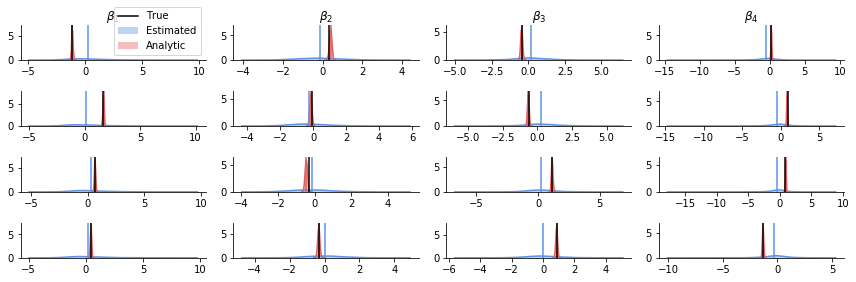

Wall time: 6.11 s


In [12]:
%%time
plot_true_est_posterior(model, bayesian_regression, n_samples_posterior, 
                        theta_test2, X_test2, params_names, figsize=(12, 4))

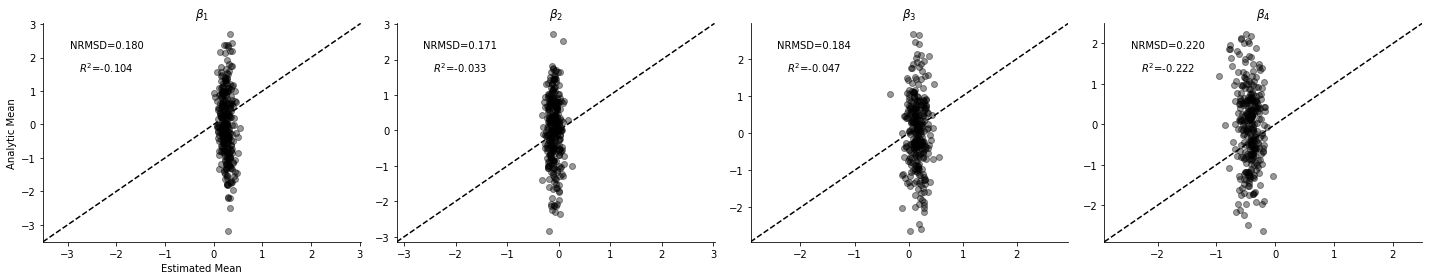

Wall time: 3.21 s


In [14]:
%%time
plot_true_est_scatter(model, bayesian_regression, n_samples_posterior, X_test, theta_test, params_names)

## 100000 iterations
<p> The model thus sees batch_size * iterations data points. </p>

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


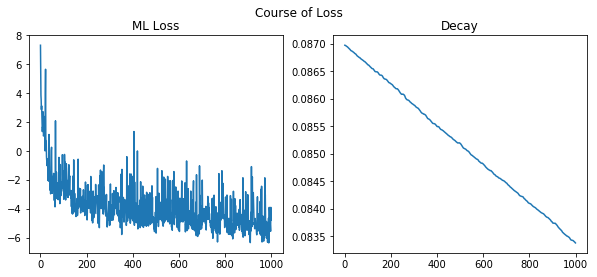

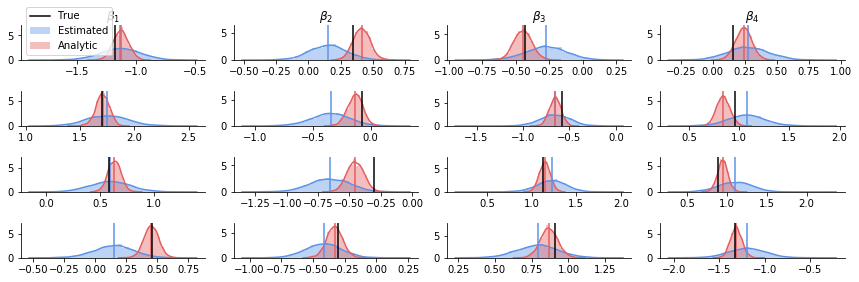

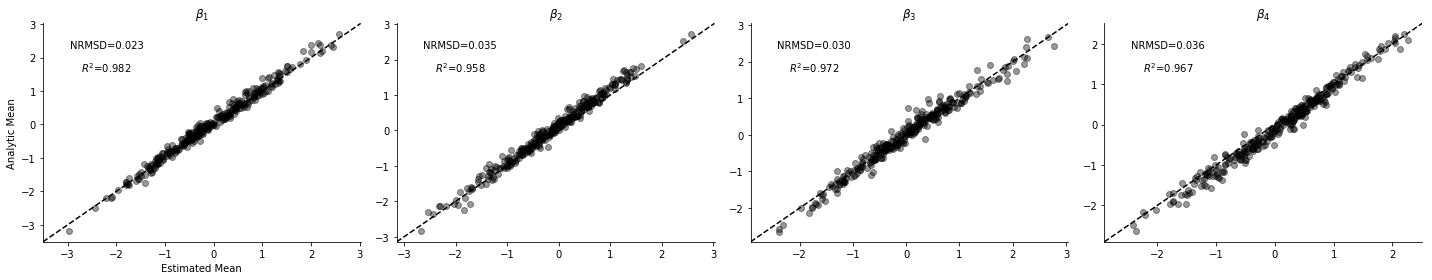

KeyboardInterrupt: 

In [15]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_loop_active(model, optimizer, bayesian_regression, iterations_per_epoch, 
                            batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                            global_step=global_step, ckpt_name='Bayesian_Regression_{}'.format(ep))
        plot_losses(losses, figsize=(10, 4))
        plot_true_est_posterior(model, bayesian_regression, n_samples_posterior, 
                        theta_test2, X_test2, params_names, figsize=(12, 4))
        plot_true_est_scatter(model, bayesian_regression, n_samples_posterior, X_test, theta_test, params_names)

In [ ]:
plot_true_est_posterior(model, bayesian_regression, 5000, 
                        theta_test2, X_test2, params_names, figsize=(12, 4))

In [ ]:
plot_true_est_scatter(model, bayesian_regression, n_samples_posterior, X_test, theta_test, params_names)

### Save model

In [ ]:
model.save_weights('models/bayesian_regression_rnn_40k_final_decay')

### Plot approximate posteriors vs analytic posteriors

#### N = 50

In [ ]:
X_test, theta_test = bayesian_regression(n_test, n=50)
X_test2, theta_test2 = bayesian_regression(n_test2, n=50)

In [ ]:
%%time
plot_true_est_posterior(model, bayesian_regression, 5000, 
                        theta_test2, X_test2, params_names, figsize=(12, 4))

In [ ]:
%%time
plot_true_est_scatter(model, bayesian_regression, n_samples_posterior, X_test, theta_test, params_names)

#### N = 100

In [ ]:
X_test, theta_test = bayesian_regression(n_test, n=50)
X_test2, theta_test2 = bayesian_regression(10, n=50)

In [ ]:
%%time
plot_true_est_posterior(model, bayesian_regression, 5000, 
                        theta_test2, X_test2, params_names, figsize=(15, 20))

In [ ]:
%%time
plot_true_est_scatter(model, bayesian_regression, n_samples_posterior, X_test, theta_test, params_names)

#### N = 250

In [ ]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True, n=250)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=250)

In [ ]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

In [ ]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

#### N = 500

In [ ]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True, n=500)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=500)

In [ ]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

In [ ]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

## Load model

In [ ]:
model.load_weights('models/bayesian_regression_rnn_40k_final_decay')

## Plots for paper

In [ ]:
X_test, Y_test = b_reg.generate_multiple_datasets(3, to_tensor=True, n=100)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=100)

In [ ]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names, figsize=(15, 5), filename='regression')

In [ ]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names, filename='regression')

In [ ]:
%%time
mmds = mmd_plot(model, b_reg, 500, X_test2, Y_test2)